# Genetic Algorithm

## Purpose:
Finding the maximum value of a positive function for a given domain.

## Set the parameters

- Population size
- The domain of the function
- The positive function which should be maximized
- The precision used for the discretization of the domain
- The crossover probability
- The mutation probability
- The number of generations the algorithm should run
- Elitism selection fleg

In [1]:
population_size = 20
function_domain = [-4, 5]
function = "-x**2+x+20"
precision = 6
crossover_probability = 0.25
mutation_probability = 0.01
number_of_generations = 50

flag_elitism_selection = True

## Imports

In [2]:
import random
import matplotlib.pyplot as plt

## Global variables

In [3]:
total_bits = None
file = open("Evolution.txt", "w") 

history_best = []
history_average = []

## Write the chosen parameters to file

In [4]:
file.write(f"Population size:        {population_size}\n")
file.write(f"Function domain:        {function_domain}\n")
file.write(f"Function:               {function}\n")
file.write(f"Precision:              {precision}\n")
file.write(f"Crossover probability:  {crossover_probability}\n")
file.write(f"Mutation probability:   {mutation_probability}\n")
file.write(f"Number of generations:  {number_of_generations}\n")
file.write(f"Flag elitism selection: {flag_elitism_selection}\n")
file.write("\n\n\n")

3

## Functions

#### Determine the length of the chromosome based on the given domain and precision

The chromosomes are arrays of 0 and 1 representing a binary number.

We will encode in the following way:
- total_bits = ceil ( log2 ( (b-a) / 10^p ) )

In [5]:
def NumberOfBitsNeeded(number):
    power_2 = 0
    while (2 ** power_2 < number):
        power_2 += 1
    return power_2
    

def GetChromosomeLength():
    global function_domain, precision, total_bits
    
    total_bits = NumberOfBitsNeeded((function_domain[1] - function_domain[0]) * 10**precision)

#### Get the numeric value of a chromosome

We will decode in the following way:
- (b - a) / ( 2^total_bits - 1) * base10(chromosome) + a

In [6]:
def GetChromosomeNumericValue(chromosome):
    global total_bits, precision
    
    power_2 = total_bits - 1
    numeric_value = 0
    
    for bit in chromosome:
        numeric_value += bit * 2**power_2
        power_2 -= 1
        
    numeric_value *= (function_domain[1] - function_domain[0]) / (2**total_bits - 1)    
        
    numeric_value += function_domain[0]
        
    return round(numeric_value, precision)

#### Get fitness of a chromosome

In [7]:
def GetChromosomeFitness(chromosome):
    global function
    
    numeric_value = GetChromosomeNumericValue(chromosome)
    fitness = eval(function, {"x": numeric_value})
    
    return round(fitness, precision)

#### Generate starting population

In [8]:
def GeneratePopulation():
    global population_size, total_bits
    
    GetChromosomeLength()
    
    population = []
    
    for i in range(population_size):
        chromosome = []
        for j in range(total_bits):
            chromosome.append(random.randint(0, 1))
        population.append(chromosome)
    
    return population

#### CrossOver

In [9]:
def CrossOver(population):
    global crossover_probability
    
    # Fitness proportionate selection
    
    total_fitness = sum([ GetChromosomeFitness(chromosome) for chromosome in population ])
    selection_probabilities = [ GetChromosomeFitness(chromosome) / total_fitness for chromosome in population ]
    
    file.write("Fitness proportionate selection:\n")
    for i in range(len(population)):
        file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in population[i]])}     x = {GetChromosomeNumericValue(population[i]) :<10}     f = {GetChromosomeFitness(population[i]) :<10}     probability = {selection_probabilities[i]}\n")
    file.write("\n")
    
    selection_q = [0]
    for selection_probability in selection_probabilities:
        selection_q.append(selection_q[-1] + selection_probability)
    selection_q[-1] = 1.0
    
    file.write("Selection intervals:\n")
    file.write(f"    {'    '.join(str(x) for x in selection_q)}\n\n")
    
    
    # Roulette
    
    file.write("Roulette:\n")
    
    selected_population = []
    
    for _ in range(len(population)):
        u = random.uniform(0, 1)
        
        # Binary search for minimum ans where u <= selection_q[ans]
        
        left = 1
        right = len(selection_q)-1
        ans = None
        
        while left <= right:
            middle = (left + right) // 2
            if (u <= selection_q[middle]):
                ans = middle
                right = middle - 1
            else:
                left = middle + 1
        
        # Chromosome ans-1 is selected
        
        file.write(f"    u = {u :<20} -> we select chromosome {ans}\n")
        
        selected_population.append([bit for bit in population[ans-1]]) # create a copy not a reference
    
    file.write("\n")
    
    
    # Cross Over
    
    file.write(f"Crossing Over (probability = {crossover_probability}):\n")
    
    new_population = []
    crossover_population = []
    
    for i in range(len(selected_population)):
        u = random.uniform(0, 1)
        
        if u < crossover_probability:
            crossover_population.append(selected_population[i])
            file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in selected_population[i]])}     u = {u :<20} < {crossover_probability} SELECTED\n")
        else:
            new_population.append(selected_population[i])
            file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in selected_population[i]])}     u = {u}\n")
    file.write("\n")        
    
    
    if len(crossover_population) % 2: 
        new_population.append(crossover_population[-1]) 
        crossover_population = crossover_population[:-1] # remove last added chromosome if odd number
        file.write("Last chromosome was deselected in order to keep the number even.\n\n")
    
    for i in range(0, len(crossover_population), 2):
        first_chromosome = crossover_population[i]
        second_chromosome = crossover_population[i+1]
        
        crossover_point = random.randint(0, len(first_chromosome))
        
        first_crossover_chromosome = first_chromosome[:crossover_point] + second_chromosome[crossover_point:]
        second_crossover_chromosome = second_chromosome[:crossover_point] + first_chromosome[crossover_point:]

        file.write(f"Crossing Over:\n")
        file.write(f"    First chromosome:  {''.join([str(bit) for bit in first_chromosome])}\n")
        file.write(f"    Second chromosome: {''.join([str(bit) for bit in second_chromosome])}\n")
        file.write(f"    Cross Over Point:  {crossover_point}\n")
        file.write(f"    Result 1: {''.join([str(bit) for bit in first_crossover_chromosome])}\n")
        file.write(f"    Result 2: {''.join([str(bit) for bit in second_crossover_chromosome])}\n")
        file.write("\n")
        
        new_population.append(first_crossover_chromosome)
        new_population.append(second_crossover_chromosome)
    
    return new_population
    

#### Mutation

In [10]:
def Mutation(population):
    global mutation_probability
    
    file.write(f"Mutation (probability = {mutation_probability}):\n")
    
    new_population = []
    
    for i in range(len(population)):
        chromosome = population[i]
        
        new_chromosome = []
        
        for j in range(len(chromosome)):
            bit = chromosome[j]

            u = random.uniform(0, 1)
            
            if u < mutation_probability:
                file.write(f"    Mutated gene {j+1 :<5} from chromosome {i+1 :<5} (changed from {bit} to {bit ^ 1})\n")
                new_chromosome.append(bit ^ 1)
            else:
                new_chromosome.append(bit)
        
        new_population.append(new_chromosome)
    
    file.write("\n")
    
    return new_population


## Compute Function

In [11]:
def Compute():
    global file, history_best, history_average
    
    population = GeneratePopulation()
    
    file.write("Initial population:\n")
    for i in range(len(population)):
        file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in population[i]])}     x = {GetChromosomeNumericValue(population[i]) :<10}     f = {GetChromosomeFitness(population[i]) :<10}\n")
    file.write("\n")
    
    
    for generation in range(number_of_generations):
        
        best = max([GetChromosomeFitness(chromosome) for chromosome in population])
        average = sum([GetChromosomeFitness(chromosome) for chromosome in population]) / len(population)
        
        history_best.append(best)
        history_average.append(average)
        
        print(f"GENERATION {generation+1}")
        print(f"BEST fitness:    {best}")
        print(f"AVERAGE fitness: {average}")
        print()
        
        file.write(f"\n\n\nGENERATION {generation+1}\n\n")
        file.write(f"BEST fitness:    {best}\n")
        file.write(f"AVERAGE fitness: {average}\n")
        file.write("\n")
        
        
        population = sorted(population, key = lambda chromosome: GetChromosomeFitness(chromosome), reverse=True) # sort by fitness descending
        
        file.write("Population (sorted by fitness descending):\n")
        for i in range(len(population)):
            file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in population[i]])}     x = {GetChromosomeNumericValue(population[i]) :<10}     f = {GetChromosomeFitness(population[i]) :<10}\n")
        file.write("\n")
        
        
        new_population = []
        
        if flag_elitism_selection:
            file.write("Elitism selection is flagged so the chromosome with the best fitness is now removed from the population and directly insterted in the new one.\n")
            file.write(f" Best: {''.join([str(bit) for bit in population[0]])}     x = {GetChromosomeNumericValue(population[0]) :<10}     f = {GetChromosomeFitness(population[0]) :<10}\n")
            file.write("\n")
            
            new_population.append(population[0])
            population = population[1:]
        
        
        crossover_population = CrossOver(population)
        crossover_population = sorted(crossover_population, key = lambda chromosome: GetChromosomeFitness(chromosome), reverse=True)
        
        file.write("After cross over (sorted by fitness descending):\n")
        for i in range(len(crossover_population)):
            file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in crossover_population[i]])}     x = {GetChromosomeNumericValue(crossover_population[i]) :<10}     f = {GetChromosomeFitness(crossover_population[i]) :<10}\n")
        file.write("\n")
        
        
        mutated_population = Mutation(crossover_population)
        
        file.write("After mutation:\n")
        for i in range(len(mutated_population)):
            file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in mutated_population[i]])}     x = {GetChromosomeNumericValue(mutated_population[i]) :<10}     f = {GetChromosomeFitness(mutated_population[i]) :<10}\n")
        file.write("\n")
        
        new_population += mutated_population
        
        population = new_population
        
        
    # FINAL    
    best = max([GetChromosomeFitness(chromosome) for chromosome in population])
    average = sum([GetChromosomeFitness(chromosome) for chromosome in population]) / len(population)

    history_best.append(best)
    history_average.append(average)

    print(f"FINAL")
    print(f"BEST fitness:    {best}")
    print(f"AVERAGE fitness: {average}")
    print()

    file.write(f"\n\n\nFINAL\n\n")
    file.write(f"BEST fitness:    {best}\n")
    file.write(f"AVERAGE fitness: {average}\n")
    file.write("\n")


    population = sorted(population, key = lambda chromosome: GetChromosomeFitness(chromosome), reverse=True) # sort by fitness descending

    file.write("Final population (sorted by fitness descending):\n")
    for i in range(len(population)):
        file.write(f"{i+1 :>5}: {''.join([str(bit) for bit in population[i]])}     x = {GetChromosomeNumericValue(population[i]) :<10}     f = {GetChromosomeFitness(population[i]) :<10}\n")
    file.write("\n")
    
    
    best_chromosome = population[0]
    
    print("----------------------------------")
    print(f"Best chromosome:   {''.join([str(bit) for bit in best_chromosome])}")
    print(f"Numeric value:     {GetChromosomeNumericValue(best_chromosome)}")
    print(f"Value in function: {GetChromosomeFitness(best_chromosome)}")
    
          
    file.write("----------------------------------\n\n")
    file.write(f"Best chromosome:   {''.join([str(bit) for bit in best_chromosome])}\n")
    file.write(f"Numeric value:     {GetChromosomeNumericValue(best_chromosome)}\n")
    file.write(f"Value in function: {GetChromosomeFitness(best_chromosome)}\n")
    

## Compute with the given parameters

In [12]:
Compute()

file.close()

GENERATION 1
BEST fitness:    20.234888
AVERAGE fitness: 15.261793149999999

GENERATION 2
BEST fitness:    20.234888
AVERAGE fitness: 16.394096700000002

GENERATION 3
BEST fitness:    20.234888
AVERAGE fitness: 17.773032949999997

GENERATION 4
BEST fitness:    20.234888
AVERAGE fitness: 17.920137550000007

GENERATION 5
BEST fitness:    20.234888
AVERAGE fitness: 19.3695627

GENERATION 6
BEST fitness:    20.234888
AVERAGE fitness: 19.286705699999995

GENERATION 7
BEST fitness:    20.234888
AVERAGE fitness: 19.42758205

GENERATION 8
BEST fitness:    20.234888
AVERAGE fitness: 19.535033249999998

GENERATION 9
BEST fitness:    20.234888
AVERAGE fitness: 18.91865145

GENERATION 10
BEST fitness:    20.234888
AVERAGE fitness: 18.534983450000002

GENERATION 11
BEST fitness:    20.244213
AVERAGE fitness: 19.246551850000003

GENERATION 12
BEST fitness:    20.244213
AVERAGE fitness: 19.9720953

GENERATION 13
BEST fitness:    20.244213
AVERAGE fitness: 19.990093050000002

GENERATION 14
BEST fitnes

## Generate graphs

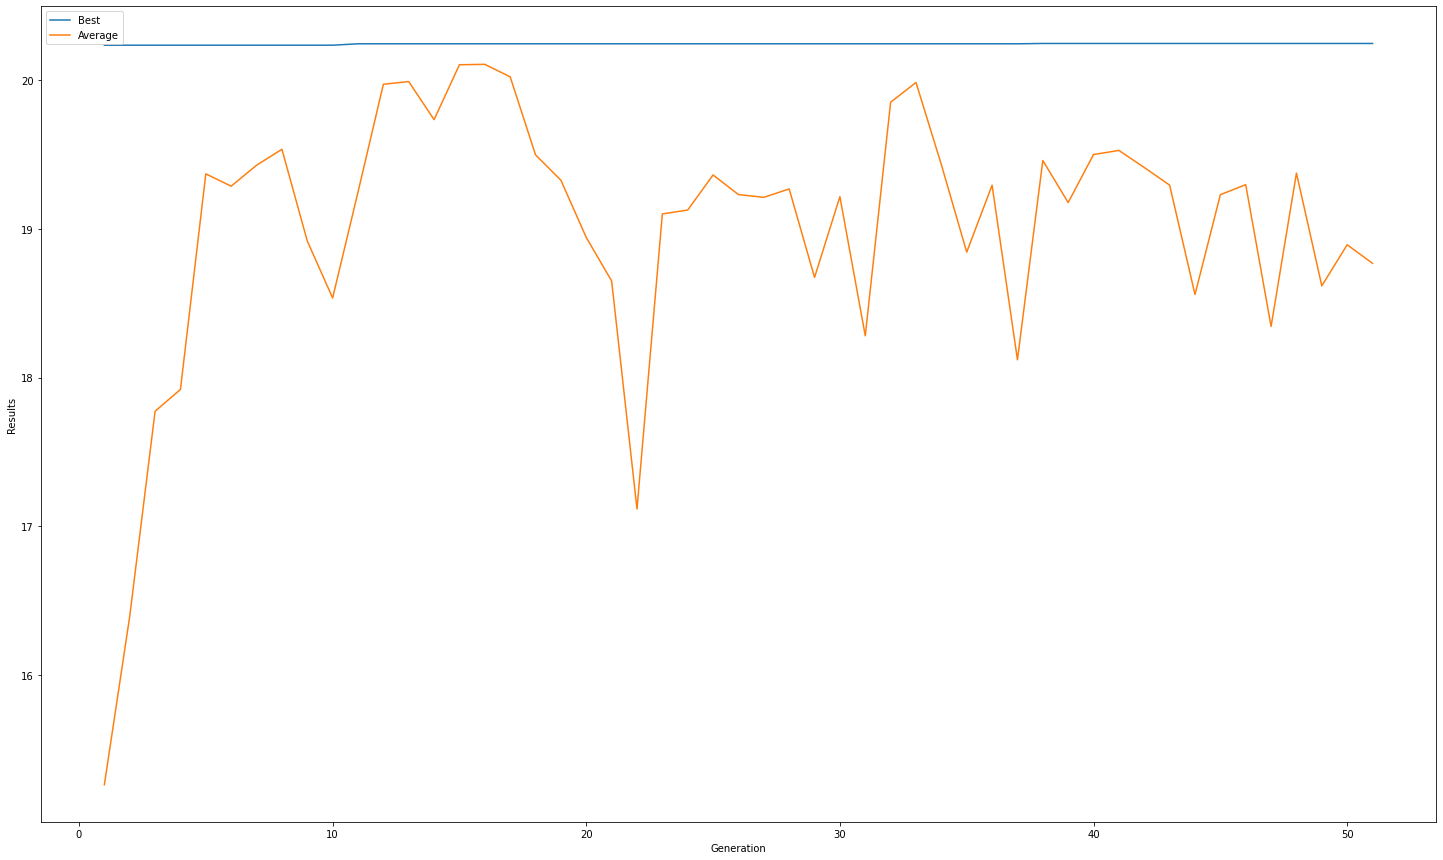

In [13]:
index = [x for x in range(1, len(history_best) + 1)]

plt.figure(figsize=(25,15))

plt.plot(index, history_best, label = "Best")
plt.plot(index, history_average, label = "Average")
 
plt.xlabel('Generation')
plt.ylabel('Results')

plt.legend()
plt.show()

## Output file

In [14]:
file_read = open("Evolution.txt", "r")
content = file_read.read()
print(content)
file_read.close()

Population size:        20
Function domain:        [-4, 5]
Function:               -x**2+x+20
Precision:              6
Crossover probability:  0.25
Mutation probability:   0.01
Number of generations:  50
Flag elitism selection: True



Initial population:
    1: 011000110100110010010100     x = -0.509015      f = 19.231889 
    2: 011110011001011010010011     x = 0.274585       f = 20.199188 
    3: 001110101100010010000111     x = -1.933948      f = 14.325897 
    4: 110011110000111100010111     x = 3.279416       f = 12.524847 
    5: 110110100110110111100100     x = 3.679154       f = 10.14298  
    6: 010010101101011101001111     x = -1.368869      f = 16.757329 
    7: 100111100010101101100011     x = 1.560646       f = 19.12503  
    8: 111011001010110001101001     x = 4.320552       f = 5.653382  
    9: 010000111001110011000111     x = -1.623001      f = 15.742867 
   10: 000000110100111000000100     x = -3.883817      f = 1.032149  
   11: 100000110111111100101010     x = 0.6